In [4]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import multiprocessing as mp
import scipy.stats as st

In [5]:
basePath = '../sims.TNG/TNG300-1/output/'
SnapNum = 99

In [6]:
threshold_mass = 10**14.5 # Minimum masses of the halos to select

In [7]:
required_snapshots = [99, 33, 25, 13, 8] # Corresponding to their respective redshifts
tot_snaps = len(required_snapshots)
# tot_snaps

In [8]:
redshifts = []
for i in range(tot_snaps):
    header = il.groupcat.loadHeader(basePath, required_snapshots[i])
    redshifts.append(round(header['Redshift']))
redshifts

[0, 2, 3, 6, 8]

In [9]:
# Defining a function for unit conversion
def UnitConversion(array, SnapNum, unit):
    header = il.groupcat.loadHeader(basePath, SnapNum)
    h = header['HubbleParam']
    a = header['Time']
    if unit == 'mass':
        array = array * 1e10 / h # In Msun unit
    if unit == 'length':
        array = array * a / (1e3 * h) # In Mpc unit
    return array

In [10]:
fields = ['Group_M_Crit200', 'GroupFirstSub']

In [11]:
halos = il.groupcat.loadHalos(basePath, SnapNum, fields=fields)

In [12]:
halos_mass = UnitConversion(halos['Group_M_Crit200'], SnapNum, 'mass')
halos_mass

array([1.5357900e+15, 1.3073401e+15, 1.0333144e+15, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [13]:
# Selecting the halos above a certain threshold mass
halo_IDs = np.nonzero(halos_mass >= threshold_mass)
halo_IDs[0], len(halo_IDs[0])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 30, 31, 32, 33, 34, 35, 36,
        39, 41, 43, 44, 48, 49, 50]),
 41)

In [14]:
# Extracting the central subhalos of the selected halos
sub_halos_ID = halos['GroupFirstSub'][halo_IDs]
n = len(sub_halos_ID)
# sub_halos_ID

In [18]:
sub_halos_ID

array([     0,  11748,  17908,  22736,  27878,  33174,  37492,  42631,
        47315,  51512,  55060,  58081,  61682,  64929,  68209,  70146,
        72656,  75826,  78522,  81618,  84201,  86933,  89298,  92076,
        94753, 102598, 104399, 109278, 111937, 114186, 116080, 118255,
       120494, 122240, 128624, 132753, 136963, 138686, 146890, 148391,
       150265], dtype=int32)

In [37]:
BH_id = []
# To extract the particle IDs of the SMBH at z = 0
for i in range(n):
    sh = il.snapshot.loadSubhalo(basePath, SnapNum, sub_halos_ID[i], partType=5, fields=['ParticleIDs', 'BH_Mass'])
    bhm = UnitConversion(sh['BH_Mass'], SnapNum, 'mass')
    bh_m = np.take_along_axis(bhm, np.argsort(bhm), axis=0)
    bh_i = np.take_along_axis(sh['ParticleIDs'], np.argsort(bhm), axis=0)
    BH_id.append(bh_i[-1])
BH_id = np.array(BH_id)

In [38]:
BH_id

array([145792751611, 146008515631, 146024967621, 145973083558,
       145954269746, 145228058882, 145646978813, 145491017598,
       145486822983, 145926805680, 145969177686, 145651676452,
       145062607851, 145540593147, 145923499830, 145939352018,
       145566452292, 145587116313, 146025445951, 146018540576,
       145655835515, 145635927482, 145260230045, 146014041209,
       144161041404, 145932569582, 145782862901, 145561831669,
       145281421373, 145592793469, 145422147408, 145942446505,
       144615398666, 145339132879, 145630395543, 144971498212,
       145748984706, 145892434363, 145692869598, 144445941187,
       145942492579], dtype=uint64)

In [46]:
fields = ['SnapNum', 'Group_M_Crit200', 'SubhaloGrNr']

In [47]:
trees = [{} for _ in range(n)]

In [48]:
# Loading the merger trees of different subhalos using the Sublink algorithm
for i in range(n):
    trees[i] = il.sublink.loadTree(basePath, SnapNum, sub_halos_ID[i], fields=fields, onlyMPB=True)

In [50]:
# Initialising the required arrays
halo_mass = [[] for _ in range(tot_snaps)]
halo_id = [[] for _ in range(tot_snaps)]

In [51]:
# Extracting the masses for various snapshots
for i in range(tot_snaps):
    for tree in trees:
        halo_mass[i].extend(UnitConversion(tree['Group_M_Crit200'][tree['SnapNum'] == required_snapshots[i]], required_snapshots[i], 'mass'))
        halo_id[i].extend(tree['SubhaloGrNr'][tree['SnapNum'] == required_snapshots[i]])
    halo_mass[i] = np.array(halo_mass[i])  
    halo_id[i] = np.array(halo_id[i])  

In [55]:
halo_id

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 30, 31, 32, 33, 34, 35, 36,
        39, 41, 43, 44, 48, 49, 50], dtype=int32),
 array([   2,   26,    1,  226,    3,    0,   65,  216,   29,    8,  106,
         198,  167,   19,    4,   56,   28,   47,  172,  137, 3858,    7,
         604,  207,  346,   22,   78,  397,  229,   21,  486,  168,   10,
         231,   94,  109,   15,   20,   14,  367,  209], dtype=int32),
 array([   1,   92,    0,   60,    4,    5,   51,   83,   27,   17,   28,
        1264,  929,   87,    9,   54,  218,   69,  860,  132, 2415,   11,
         557,  142,  199,    7,  188,  187,  848,  976, 1520, 5245,   19,
         156,   90,  133,    3,   34,   10, 3476,  116], dtype=int32),
 array([   18,   162,     8,    37,  4820,     0, 14958,   594,    11,
        11469,    33, 43321,  1214,    14,    54,  1336,   104,   645,
         1568,   127,  1572,    70,  1868,  8079,    49,    23,   599

In [52]:
bh_mass = [[] for _ in range(tot_snaps)]
part_id = [[] for _ in range(tot_snaps)]
error = []

for i in range(tot_snaps):
    for j in range(n):
        
        bh_data = il.snapshot.loadHalo(basePath, required_snapshots[i], halo_id[i][j], partType=5, fields=['BH_Mass', 'ParticleIDs'])
        if bh_data['count'] > 0:
            bh_mass[i].append(UnitConversion(bh_data['BH_Mass'][bh_data['ParticleIDs']==BH_id[j]], required_snapshots[i], 'mass'))
            part_id[i].append(bh_data['ParticleIDs'][bh_data['ParticleIDs']==BH_id[j]])
        else:
            error.append((i, j))
            
    bh_mass[i] = np.array(bh_mass[i])
    part_id[i] = np.array(part_id[i])

In [62]:
bh_data = il.snapshot.loadHalo(basePath, required_snapshots[1], halo_id[1][0], partType=5, fields=['BH_Mass', 'ParticleIDs'])

In [63]:
bh_data['ParticleIDs'], len(bh_data['ParticleIDs'])

(array([125617942208, 125698005914, 124147999339, 122807408295,
        116675556347, 124986807252, 125684453438, 122595555333,
        123152201661, 124016031883, 117685853076, 116515537445,
        124489214350, 117747420205, 123858346092, 117379373853,
        119285876961, 121793109914, 115720435200, 116663216661,
        123539831649, 116221682715, 118280031586, 121930281565,
        125460412951, 116913188925, 116159179622, 118627227745,
        117205108631, 102933773295, 103256420475, 122872718565,
        120284731622, 116174483893, 116165659403], dtype=uint64),
 35)

In [68]:
halo_data = il.groupcat.loadSingle(basePath, required_snapshots[1], haloID=halo_id[1][0])

In [70]:
halo_data['GroupLenType']

array([1371146, 1926507,       0,       0,  297889,      35], dtype=int32)

In [13]:
halo_mass_99 = halos_mass[np.where(halos['GroupFirstSub'] > -1)]

In [13]:
# halo_mass_99

In [14]:
req_subhalo_ID = halos['GroupFirstSub'][np.nonzero(halos['GroupFirstSub'] > -1)[0]]

In [15]:
len(req_subhalo_ID)

11504190

In [16]:
# To load the masses of the all the bh of the central galaxies (if they exist)

In [16]:
fields=['SubhaloLenType']

In [17]:
subhalos = il.groupcat.loadSubhalos(basePath, SnapNum, fields=fields)

In [18]:
bh_data = [subhalo[5] for subhalo in subhalos]

In [19]:
nonzero_bh = np.nonzero(bh_data)

In [20]:
common_subhalos = np.intersect1d(nonzero_bh[0], req_subhalo_ID)

In [21]:
len(common_subhalos)

515575

In [22]:
def process_subhalo(subhalo_id):
    bh = il.snapshot.loadSubhalo(basePath, SnapNum, subhalo_id, partType=5, fields=['BH_Mass', 'Masses'])
    if bh['count'] > 0:
        return UnitConversion(bh['BH_Mass'][0], SnapNum, 'mass')
    return None

def process_subhalos(subhalo_ids):
    with mp.Pool(9) as pool:
        results = pool.map(process_subhalo, subhalo_ids)
    return results

In [23]:
bh_mass_99 = []

In [24]:
count = 0
chunk_size = 100000
chunks = [common_subhalos[i:i + chunk_size] for i in range(0, len(common_subhalos), chunk_size)]

for chunk in chunks:
    bh_mass_99 += [mass for mass in process_subhalos(chunk) if mass is not None]
    print(count+1, end=' ')
    count += 1

1 2 3 4 5 6 

In [3]:
bh_mass_99 = np.array(bh_mass_99)
format(np.min(bh_mass_99), '.3g') # To check the minimum mass of the bh

NameError: name 'bh_mass_99' is not defined

In [26]:
len(bh_mass_99), len(halo_mass_99)

(515575, 11504190)

In [27]:
fields = ['SubhaloLenType', 'SubhaloGrNr']

In [28]:
test_sbhalo = il.groupcat.loadSubhalos(basePath, SnapNum, fields=fields)

In [29]:
nonzero_bh_halo_ID = test_sbhalo['SubhaloGrNr'][common_subhalos]

In [30]:
halo_mass_99 = halos_mass[nonzero_bh_halo_ID]

In [31]:
len(halo_mass_99) == len(bh_mass_99)

True

In [30]:
halo_mass_99

array([5.1335838e+14, 4.0175708e+14, 2.8469707e+14, ..., 2.3131827e+09,
       3.5629737e+09, 2.7295270e+09], dtype=float32)

In [31]:
bh_mass_99

array([8.74798119e+09, 1.17782641e+10, 1.07627757e+10, ...,
       1.18099039e+06, 1.18242517e+06, 1.18099146e+06])

In [114]:
# Loading the merger trees of different subhalos using the Sublink algorithm
# treessssss = il.sublink.loadTree(basePath, SnapNum, 0, fields=fields, onlyMPB=True)

In [3]:
# treessssss['SubfindID']

In [2]:
# for i in range(len(treessssss['SnapNum'])):
#     bh_data = il.snapshot.loadSubhalo(basePath, treessssss['SnapNum'][i], treessssss['SubfindID'][i], partType=5, fields=['BH_Mass', 'ParticleIDs'])
#     if bh_data['count'] > 0:
#         print(format(UnitConversion(np.take_along_axis(bh_data['BH_Mass'], np.argsort(bh_data['BH_Mass']), axis=None)[-1], treessssss['SnapNum'][i], 'mass'), '.3e'), np.take_along_axis(bh_data['ParticleIDs'], np.argsort(bh_data['BH_Mass']), axis=None)[-1])

In [48]:
# # Extracting the masses for various snapshots
# for i in range(tot_snaps):
#     for tree in trees:
#         halo_mass[i].extend(UnitConversion(tree['Group_M_Crit200'][tree['SnapNum'] == required_snapshots[i]], required_snapshots[i], 'mass'))
#         subhalo_id[i].extend(tree['SubfindID'][tree['SnapNum'] == required_snapshots[i]])
#         # total_mass[i].extend(UnitConversion(tree['GroupMassType'][tree['SnapNum'] == required_snapshots[i]], required_snapshots[i], 'mass'))
#     halo_mass[i] = np.array(halo_mass[i])  
#     subhalo_id[i] = np.array(subhalo_id[i])  
#     # total_mass[i] = np.array(total_mass[i])  

AttributeError: 'numpy.ndarray' object has no attribute 'extend'

In [44]:
# subhalo_id[0]

In [45]:
part_id

[array([[145792751611],
        [146008515631],
        [146024967621],
        [145973083558],
        [145954269746],
        [145228058882],
        [145646978813],
        [145491017598],
        [145486822983],
        [145926805680],
        [145969177686],
        [145651676452],
        [145062607851],
        [145540593147],
        [145923499830],
        [145939352018],
        [145566452292],
        [145587116313],
        [146025445951],
        [146018540576],
        [145655835515],
        [145635927482],
        [145260230045],
        [146014041209],
        [144161041404],
        [145932569582],
        [145782862901],
        [145561831669],
        [145281421373],
        [145592793469],
        [145422147408],
        [145942446505],
        [144615398666],
        [145339132879],
        [145630395543],
        [144971498212],
        [145748984706],
        [145892434363],
        [145692869598],
        [144445941187],
        [145942492579]], dtype=uint64),


In [38]:
error

[(4, 4),
 (4, 6),
 (4, 7),
 (4, 9),
 (4, 11),
 (4, 12),
 (4, 19),
 (4, 23),
 (4, 26),
 (4, 27),
 (4, 28),
 (4, 31),
 (4, 39)]

In [56]:
# part_id[8] = p_extended

In [1]:
# # Plotting the critical halo masses vs black hole masses for various snapshots
# fig, ax = plt.subplots(figsize=(16,10), layout='constrained')

# # ax.plot(halo_mass_99, bh_mass_99, 'o', markersize=3, c='gray', alpha=0.7, label='z = 0')

# cmap = cm.get_cmap('plasma')
# norm = plt.Normalize(0, n)

# for i in range(n):
#     ax.plot(redshifts, [ymass[i] for ymass in part_id], c=cmap(norm(i)))
    
#     # print
#     # print(i+1, end=', ')
    
# # ax.set_xscale('log')
# ax.set_yscale('log')
# # ax.set_xlabel('M$_{200c}$ [M$_\odot$]', fontsize='xx-large')
# # ax.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='xx-large')
# ax.legend(title='TNG300-1', title_fontsize='x-large', fontsize='large')

# # plt.tight_layout()
# plt.grid(True)
# # plt.savefig('evolutionary_track_new.png')
# plt.show()

In [39]:
# To remove the halo masses for which there is no bh mass
mask = np.ones(len(halo_mass[4]), dtype=bool)
mask[[4, 6, 7, 9, 11, 12, 19, 23, 26, 27, 28, 31, 39]] = False
filtered_halo_mass = halo_mass[4][mask]

In [40]:
halo_mass[4] = filtered_halo_mass

In [41]:
# To make the modified array the same length as the other redshifts (by adding 0s)
zeros = np.zeros((n - len(halo_mass[4])), dtype=halo_mass[4].dtype)
zeros1 = np.full((n - len(bh_mass[4])), np.min(bh_mass_99), dtype=bh_mass[4].dtype)
halo_mass_extended = np.concatenate((halo_mass[4], zeros))
bh_mass_extended = np.concatenate((bh_mass[4], zeros))

In [42]:
halo_mass[4] = halo_mass_extended
bh_mass[4] = bh_mass_extended

In [43]:
for i in range(tot_snaps):
    print(len(halo_mass[i]) == len(bh_mass[i]), end=' ')

True True True True True 

In [48]:
halo_mass[0]

array([1.5357900e+15, 1.3073401e+15, 1.0333144e+15, 8.9967022e+14,
       8.4181970e+14, 7.3352740e+14, 4.5928518e+14, 5.8122068e+14,
       3.9825161e+14, 6.4121164e+14, 6.3585347e+14, 5.4733694e+14,
       6.5518156e+14, 5.5387734e+14, 4.3728320e+14, 4.9731597e+14,
       3.7920424e+14, 4.1666149e+14, 4.0715522e+14, 4.6737187e+14,
       4.3128679e+14, 3.8214609e+14, 3.6035957e+14, 3.9222551e+14,
       3.6736489e+14, 4.5610449e+14, 4.7101947e+14, 3.8932734e+14,
       3.9017738e+14, 3.9039374e+14, 3.6959079e+14, 3.6782583e+14,
       3.8122808e+14, 3.7420798e+14, 3.3413346e+14, 3.5726082e+14,
       3.4338072e+14, 3.3250620e+14, 3.2415152e+14, 3.2403874e+14,
       3.3821059e+14], dtype=float32)

/tmp/ipykernel_2253/650380850.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma')


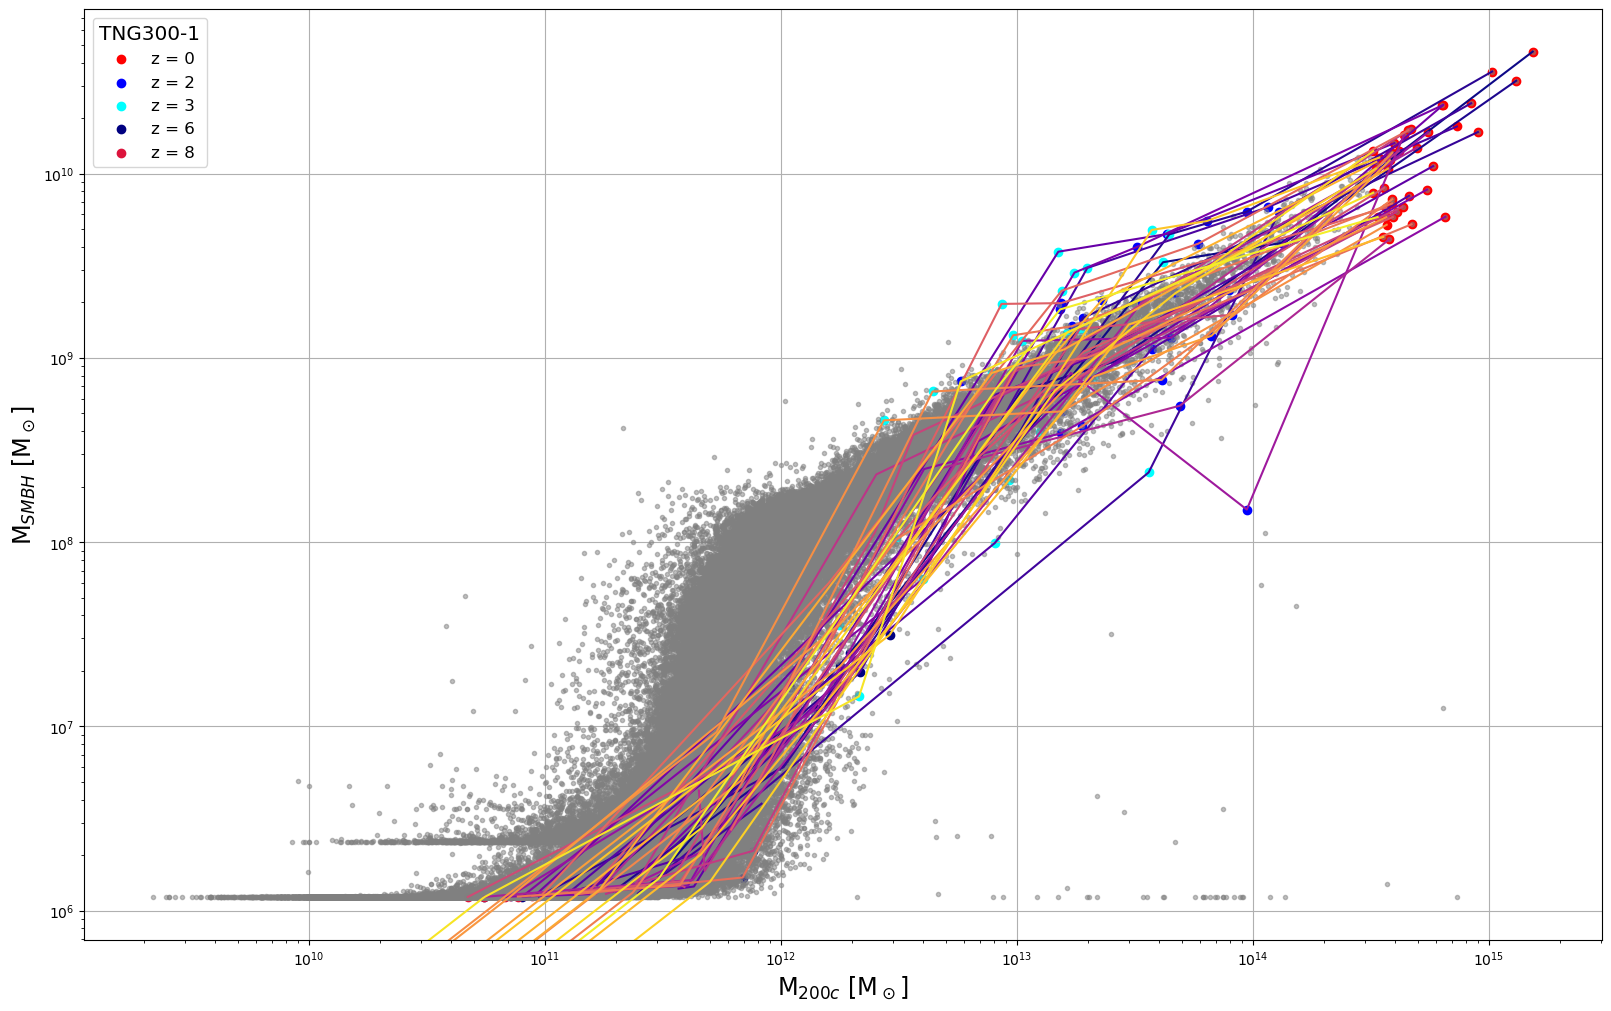

In [67]:
# Plotting the critical halo masses vs black hole masses for various snapshots
fig, ax = plt.subplots(figsize=(16,10), layout='constrained')

ax.plot(halo_mass_99, bh_mass_99, 'o', markersize=3, c='gray', alpha=0.5)

# top = 1e11
# bottom = 9e5
# right = 3e15
# left = 1e9

cmap = cm.get_cmap('plasma')
norm = plt.Normalize(0, n)

# cmap1 = cm.get_cmap('twilight')
# norm1 = plt.Normalize(0, tot_snaps)

for i in range(n):
    ax.plot([xmass[i] for xmass in halo_mass], [ymass[i] for ymass in bh_mass], c=cmap(norm(i)))

# cmap = cm.get_cmap('tab10')
# norm = plt.Normalize(0, tot_snaps)
size = np.arange(0.1, 6, tot_snaps)

for i in range(tot_snaps):
    ax.scatter(halo_mass[i], bh_mass[i], c=cyan, s=size[i], label=f'z = {redshifts[i]}')
    # print(i+1, end=', ')
    
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(left=left, right=right)
# ax.set_ylim(top=top, bottom=bottom)
ax.set_xlabel('M$_{200c}$ [M$_\odot$]', fontsize='xx-large')
ax.set_ylabel('M$_{SMBH}$ [M$_\odot$]', fontsize='xx-large')
ax.legend(title='TNG300-1', title_fontsize='x-large', fontsize='large')

# plt.tight_layout()
plt.grid(True)
plt.savefig('evolutionary_track_new2.png')
plt.show()

In [136]:
# format(10**6/ 10**.2, '.3g')

In [137]:
# y_med, _, _, = st.binned_statistic(halo_mass_99, bh_mass_99, statistic='median', bins=7e5)
# x_med, _, _, = st.binned_statistic(bh_mass_99, halo_mass_99, statistic='median', bins=7e5)